# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.41KFile/s] 


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

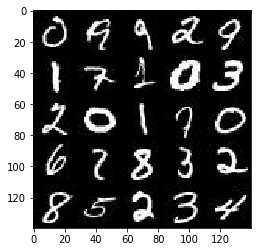

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

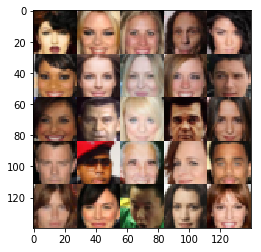

In [6]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [10]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images_tensor = tf.placeholder(tf.float32, (None, image_width,image_height, image_channels), name='real_image_input')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return real_input_images_tensor,input_z, learning_rate



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [12]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input Layer is 28x28x3Channels
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 =tf.maximum(alpha*x1, x1)
        
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha*x2, x2)
        
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha*x3,x3)
        
        # 4x4x256
        
        # Flatten
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [13]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse = not is_train):
     
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1,x1)

        # 7x7x512 Now
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2,x2)
        
        # 14x14x256 Now
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3,x3)
        # 28x28x128 Now
        
        # Output Layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same', 
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x3 Now
        
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [16]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    gan_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(gan_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    gan_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    return d_loss, gan_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [17]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)    
    with tf.control_dependencies(update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [ ]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    num, width, height, depth = data_shape
    inputs_real, inputs_z, learn_rate = model_inputs(width, height, depth, z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, depth)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    saver = tf.train.Saver()
    sample_z = tf.random_uniform([10, z_dim], -1, 1)
    losses = []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images_norm = batch_images*2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run Optimizer
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images_norm,
                                               inputs_z: batch_z,
                                               learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs_real: batch_images_norm,
                                               inputs_z: batch_z,
                                               learn_rate: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({inputs_real: batch_images_norm,
                                               inputs_z: batch_z,
                                               learn_rate: learning_rate})
                    train_loss_g = g_loss.eval({inputs_real: batch_images_norm,
                                               inputs_z: batch_z,
                                               learn_rate: learning_rate})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 10, sample_z, depth, data_image_mode)
                    
        saver.save(sess, './generator.ckpt')
    return losses 
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9313... Generator Loss: 0.9734
Epoch 1/2... Discriminator Loss: 0.8716... Generator Loss: 0.9850
Epoch 1/2... Discriminator Loss: 0.4431... Generator Loss: 2.3616
Epoch 1/2... Discriminator Loss: 1.2029... Generator Loss: 1.4729
Epoch 1/2... Discriminator Loss: 1.3484... Generator Loss: 0.8403
Epoch 1/2... Discriminator Loss: 1.5390... Generator Loss: 0.8704
Epoch 1/2... Discriminator Loss: 1.5173... Generator Loss: 0.7577
Epoch 1/2... Discriminator Loss: 1.2222... Generator Loss: 1.0401
Epoch 1/2... Discriminator Loss: 1.2314... Generator Loss: 0.8369
Epoch 1/2... Discriminator Loss: 1.3847... Generator Loss: 0.8179


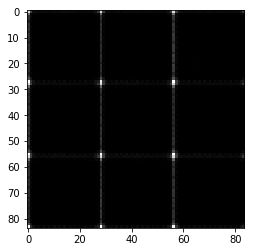

Epoch 1/2... Discriminator Loss: 1.2607... Generator Loss: 0.9037
Epoch 1/2... Discriminator Loss: 1.4982... Generator Loss: 0.7346
Epoch 1/2... Discriminator Loss: 1.3075... Generator Loss: 0.8418
Epoch 1/2... Discriminator Loss: 1.3971... Generator Loss: 0.8390
Epoch 1/2... Discriminator Loss: 1.3277... Generator Loss: 0.8447
Epoch 1/2... Discriminator Loss: 1.3804... Generator Loss: 0.7893
Epoch 1/2... Discriminator Loss: 1.2795... Generator Loss: 0.8270
Epoch 1/2... Discriminator Loss: 1.2883... Generator Loss: 0.8477
Epoch 1/2... Discriminator Loss: 1.2962... Generator Loss: 0.8183
Epoch 1/2... Discriminator Loss: 1.3799... Generator Loss: 0.8138


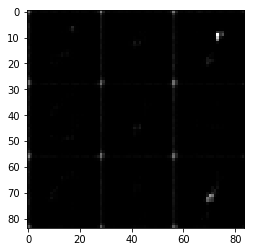

Epoch 1/2... Discriminator Loss: 1.3530... Generator Loss: 0.7928
Epoch 1/2... Discriminator Loss: 1.4026... Generator Loss: 0.7728
Epoch 1/2... Discriminator Loss: 1.4098... Generator Loss: 0.7869
Epoch 1/2... Discriminator Loss: 1.3815... Generator Loss: 0.8112
Epoch 1/2... Discriminator Loss: 1.3931... Generator Loss: 0.7987
Epoch 1/2... Discriminator Loss: 1.3539... Generator Loss: 0.8114
Epoch 1/2... Discriminator Loss: 1.3574... Generator Loss: 0.8179
Epoch 1/2... Discriminator Loss: 1.3751... Generator Loss: 0.7819
Epoch 1/2... Discriminator Loss: 1.3434... Generator Loss: 0.8326
Epoch 1/2... Discriminator Loss: 1.3732... Generator Loss: 0.7716


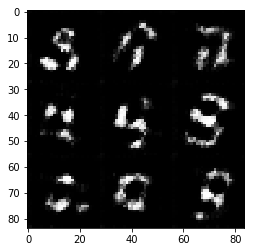

Epoch 1/2... Discriminator Loss: 1.4066... Generator Loss: 0.7665
Epoch 1/2... Discriminator Loss: 1.3625... Generator Loss: 0.8211
Epoch 1/2... Discriminator Loss: 1.3923... Generator Loss: 0.8102
Epoch 1/2... Discriminator Loss: 1.3742... Generator Loss: 0.7631
Epoch 1/2... Discriminator Loss: 1.3839... Generator Loss: 0.9016
Epoch 1/2... Discriminator Loss: 1.3722... Generator Loss: 0.7472
Epoch 1/2... Discriminator Loss: 1.3782... Generator Loss: 0.8799
Epoch 1/2... Discriminator Loss: 1.4281... Generator Loss: 0.7329
Epoch 1/2... Discriminator Loss: 1.3992... Generator Loss: 0.8533
Epoch 1/2... Discriminator Loss: 1.3980... Generator Loss: 0.7450


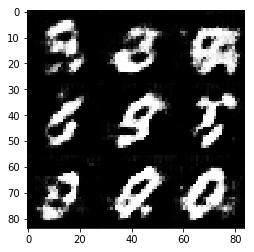

Epoch 1/2... Discriminator Loss: 1.3994... Generator Loss: 0.8358
Epoch 1/2... Discriminator Loss: 1.3756... Generator Loss: 0.7526
Epoch 1/2... Discriminator Loss: 1.3866... Generator Loss: 0.8288
Epoch 1/2... Discriminator Loss: 1.3788... Generator Loss: 0.7859
Epoch 1/2... Discriminator Loss: 1.3695... Generator Loss: 0.8328
Epoch 1/2... Discriminator Loss: 1.3755... Generator Loss: 0.7602
Epoch 2/2... Discriminator Loss: 1.3278... Generator Loss: 0.8546
Epoch 2/2... Discriminator Loss: 1.3558... Generator Loss: 0.7819
Epoch 2/2... Discriminator Loss: 1.3535... Generator Loss: 0.8044
Epoch 2/2... Discriminator Loss: 1.3688... Generator Loss: 0.8068


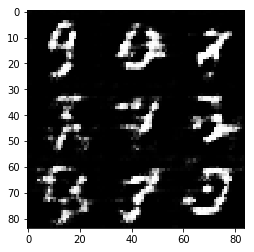

Epoch 2/2... Discriminator Loss: 1.3352... Generator Loss: 0.8131
Epoch 2/2... Discriminator Loss: 1.3420... Generator Loss: 0.8862
Epoch 2/2... Discriminator Loss: 1.3492... Generator Loss: 0.8063
Epoch 2/2... Discriminator Loss: 1.3961... Generator Loss: 0.7579
Epoch 2/2... Discriminator Loss: 1.4418... Generator Loss: 0.8431
Epoch 2/2... Discriminator Loss: 1.3449... Generator Loss: 0.7649
Epoch 2/2... Discriminator Loss: 1.3268... Generator Loss: 0.9356
Epoch 2/2... Discriminator Loss: 1.3164... Generator Loss: 0.8214
Epoch 2/2... Discriminator Loss: 1.3495... Generator Loss: 0.8035
Epoch 2/2... Discriminator Loss: 1.4041... Generator Loss: 0.8273


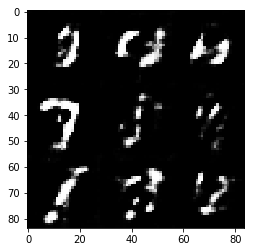

Epoch 2/2... Discriminator Loss: 1.3776... Generator Loss: 0.7096
Epoch 2/2... Discriminator Loss: 1.3421... Generator Loss: 1.0100
Epoch 2/2... Discriminator Loss: 1.2760... Generator Loss: 0.8298
Epoch 2/2... Discriminator Loss: 1.3279... Generator Loss: 0.7768
Epoch 2/2... Discriminator Loss: 1.4020... Generator Loss: 0.8425
Epoch 2/2... Discriminator Loss: 1.3791... Generator Loss: 0.7950
Epoch 2/2... Discriminator Loss: 1.3318... Generator Loss: 0.9444
Epoch 2/2... Discriminator Loss: 1.2871... Generator Loss: 0.8280
Epoch 2/2... Discriminator Loss: 1.3083... Generator Loss: 0.7618
Epoch 2/2... Discriminator Loss: 1.3244... Generator Loss: 0.8285


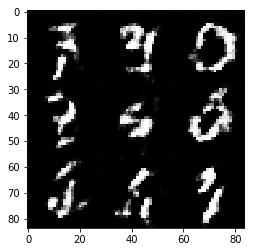

Epoch 2/2... Discriminator Loss: 1.3510... Generator Loss: 0.9267
Epoch 2/2... Discriminator Loss: 1.3211... Generator Loss: 0.8818
Epoch 2/2... Discriminator Loss: 1.2997... Generator Loss: 0.7651
Epoch 2/2... Discriminator Loss: 1.3088... Generator Loss: 0.9993
Epoch 2/2... Discriminator Loss: 1.3443... Generator Loss: 0.7911
Epoch 2/2... Discriminator Loss: 1.3105... Generator Loss: 0.7268
Epoch 2/2... Discriminator Loss: 1.3172... Generator Loss: 0.8394
Epoch 2/2... Discriminator Loss: 1.3556... Generator Loss: 0.8448
Epoch 2/2... Discriminator Loss: 1.3405... Generator Loss: 0.8235
Epoch 2/2... Discriminator Loss: 1.3037... Generator Loss: 0.7568


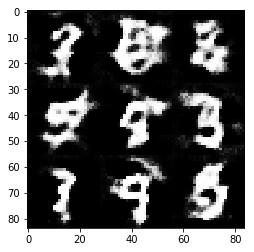

Epoch 2/2... Discriminator Loss: 1.3839... Generator Loss: 0.7815
Epoch 2/2... Discriminator Loss: 1.4173... Generator Loss: 0.8643
Epoch 2/2... Discriminator Loss: 1.3874... Generator Loss: 0.7343
Epoch 2/2... Discriminator Loss: 1.3100... Generator Loss: 0.7370
Epoch 2/2... Discriminator Loss: 1.3080... Generator Loss: 0.8633
Epoch 2/2... Discriminator Loss: 1.3801... Generator Loss: 0.7520
Epoch 2/2... Discriminator Loss: 1.4104... Generator Loss: 0.8286
Epoch 2/2... Discriminator Loss: 1.2847... Generator Loss: 0.8204
Epoch 2/2... Discriminator Loss: 1.3370... Generator Loss: 0.8736
Epoch 2/2... Discriminator Loss: 1.3581... Generator Loss: 0.9373


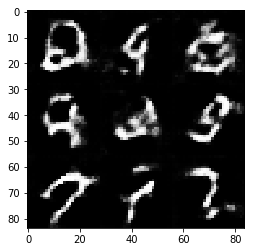

Epoch 2/2... Discriminator Loss: 1.2868... Generator Loss: 0.8626
Epoch 2/2... Discriminator Loss: 1.3780... Generator Loss: 0.7466
Epoch 2/2... Discriminator Loss: 1.3685... Generator Loss: 0.9145


In [31]:
batch_size =128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.1467... Generator Loss: 0.9193
Epoch 1/1... Discriminator Loss: 0.9485... Generator Loss: 1.2178
Epoch 1/1... Discriminator Loss: 0.6580... Generator Loss: 1.6442
Epoch 1/1... Discriminator Loss: 0.6662... Generator Loss: 1.7901
Epoch 1/1... Discriminator Loss: 0.9585... Generator Loss: 1.4772
Epoch 1/1... Discriminator Loss: 0.6332... Generator Loss: 1.9636
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 1.1433
Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 1.2935
Epoch 1/1... Discriminator Loss: 1.0597... Generator Loss: 1.9055


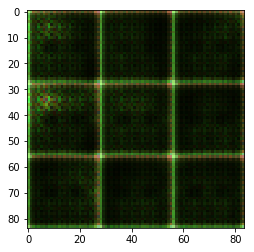

Epoch 1/1... Discriminator Loss: 0.7552... Generator Loss: 1.5437
Epoch 1/1... Discriminator Loss: 1.0871... Generator Loss: 0.9524
Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 1.2909
Epoch 1/1... Discriminator Loss: 1.3450... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 1.0762... Generator Loss: 1.0239
Epoch 1/1... Discriminator Loss: 0.9928... Generator Loss: 1.0449
Epoch 1/1... Discriminator Loss: 1.0977... Generator Loss: 1.4924
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.5076
Epoch 1/1... Discriminator Loss: 1.0302... Generator Loss: 1.1381
Epoch 1/1... Discriminator Loss: 1.5714... Generator Loss: 0.5511


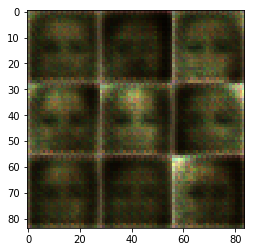

Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.5482
Epoch 1/1... Discriminator Loss: 1.5084... Generator Loss: 0.5233
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.6433
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.5885
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.6077
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.6255
Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 0.6542
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.7187


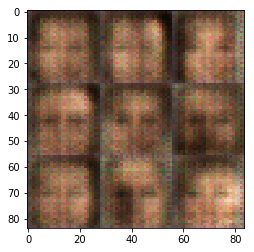

Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.7892


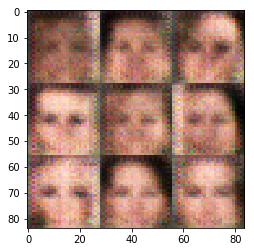

Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.8266
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.7138
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.9875
Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.9058
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.7716


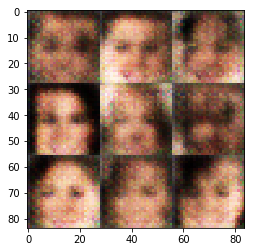

Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.8714
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.8418
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.8967


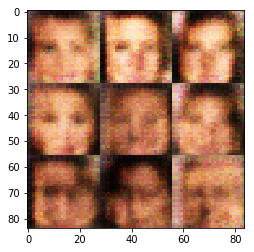

Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.7294
Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.8783
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.8772
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.8730
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.7831


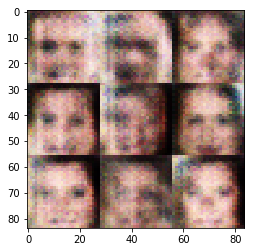

Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.7511
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.8536
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.8189
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.8478
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.8263
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.7548


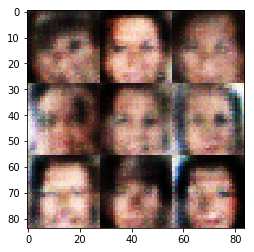

Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.9220
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.6742
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.8607
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.8345
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.7947


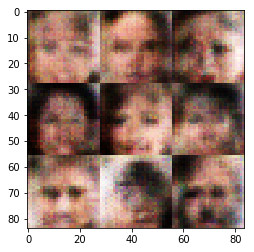

Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.8288
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.3429... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.8249
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.7488


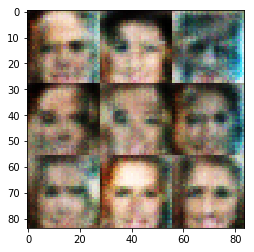

Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.8318
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.7476


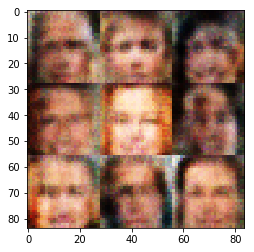

Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.8542
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.8916
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.8316


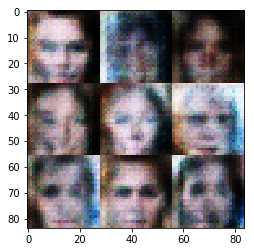

Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.7716
Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.8666
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.8520


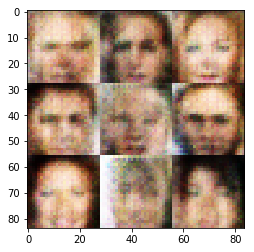

Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.8559
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.8183
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.8315
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.8227
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.7876


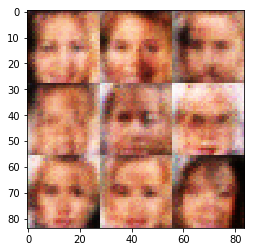

Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.8316
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.7590


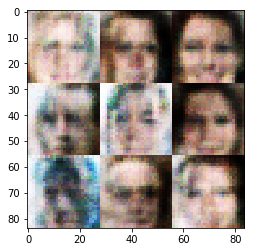

Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.8489
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.7995


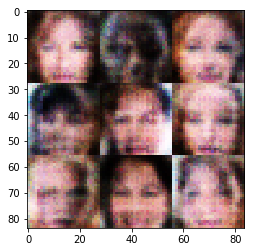

Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.8405
Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.8216
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.7830


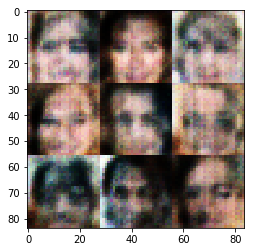

Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.8360
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.9720
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.8961


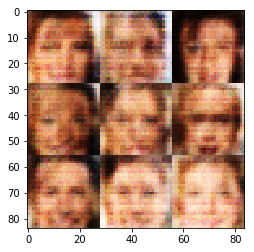

Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.8225
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.8383
Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.8766
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7438


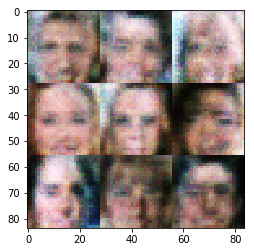

Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.8263
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.8550


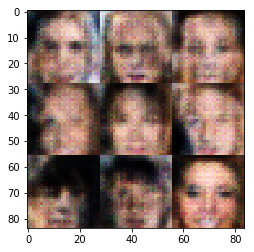

Epoch 1/1... Discriminator Loss: 0.9444... Generator Loss: 1.4981
Epoch 1/1... Discriminator Loss: 1.5311... Generator Loss: 0.5482
Epoch 1/1... Discriminator Loss: 1.1119... Generator Loss: 1.2294
Epoch 1/1... Discriminator Loss: 0.8957... Generator Loss: 1.2976
Epoch 1/1... Discriminator Loss: 0.9996... Generator Loss: 1.3184
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.3109... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.1280... Generator Loss: 1.0276
Epoch 1/1... Discriminator Loss: 1.4921... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.2064... Generator Loss: 0.8536


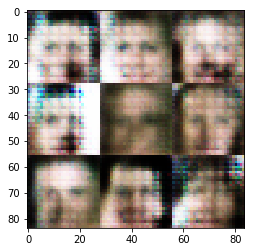

Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.9181
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.8318
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.8505
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.8317
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.8268


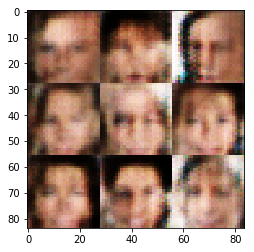

Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.8563
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.9299
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.8316
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 1.2967... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.9587
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.8672


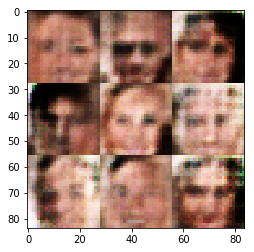

Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.7198
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.8246


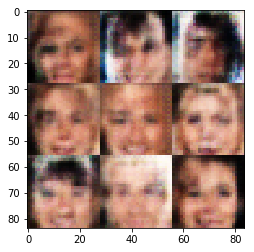

Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.8160
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.8649
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.8487
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.7817


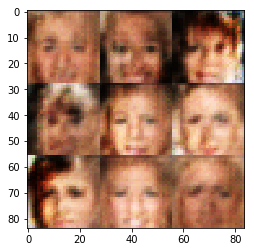

Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.8590
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.8170
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.8507
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7994


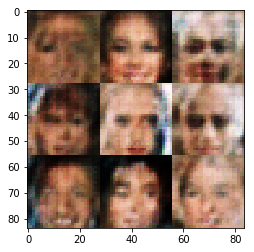

Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.7733
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.8760
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.7226
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.9099
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.7564


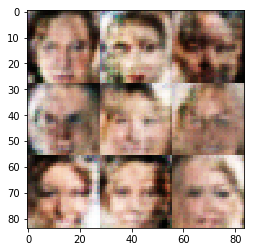

Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.8097
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.7998


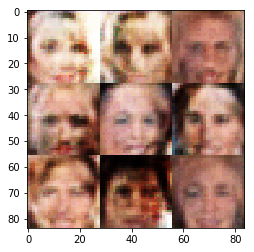

Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.8726
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.8756
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.7880


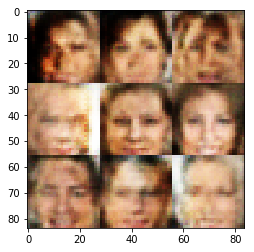

Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.8349
Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.8399
Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.9361
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 1.0162
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.7254


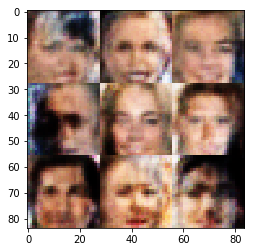

Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.8475
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.7943
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.8772
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.7872


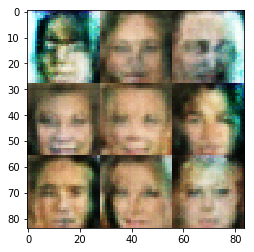

Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.7946
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.8129


In [40]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.